In [1]:
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'space']

In [3]:
#Original Training Dataset Size = 1073
newsgroups_train.filenames.shape

(1073,)

In [4]:
# Fixing the test set size to 
newsgroups_test.filenames.shape

(713,)

Let's use the tfidf vectorizer, commonly used for text.

In [5]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [6]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AUC of ROC Curve: 0.9328246582753847


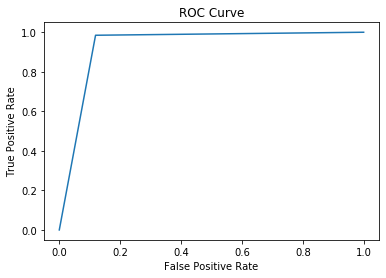

In [7]:
import scikitplot as skplt
import matplotlib.pyplot as plt

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')
fpr, tpr, thresholds = sklearn.metrics.roc_curve(newsgroups_test.target, pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
print("AUC of ROC Curve:", roc_auc)


#skplt.metrics.plot_roc_curve(newsgroups_test.target, pred)
plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr)

# Using Active Learning

In [22]:
tsv_file=open('Fetch20NewsGroup.tsv','w')

index=0
for element in newsgroups_train.data:
    tsv_file.write(element.replace("\n"," ").replace("\t"," ")+"\t"+str(newsgroups_train.target[index])+"\n")
    index=index+1
newsgroups_train.target[0]

0

In [11]:
print(len(newsgroups_train['data']))

1073


In [13]:
import pandas as pd
df = pd.read_csv("Fetch20NewsGroup.tsv", sep='\t', header=None)
print(len(df))
train_df=df
print(len(train_df))

1073
1073


In [14]:
seed_df = df.sample(n = 100)
print(seed_df)

                                                      0  1
412   From: djf@cck.coventry.ac.uk (Marvin Batty) Su...  1
628   From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
1070  From: nicho@vnet.IBM.COM (Greg Stewart-Nicholl...  1
518   From: tffreeba@indyvax.iupui.edu Subject: Re: ...  1
762   From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
...                                                 ... ..
918   From: sysmgr@king.eng.umd.edu (Doug Mohney) Su...  1
176   From: bobs@thnext.mit.edu (Robert Singleton) S...  0
589   From: aws@iti.org (Allen W. Sherzer) Subject: ...  1
51    From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
637   From: dpage@ra.csc.ti.com (Doug Page) Subject:...  1

[100 rows x 2 columns]


In [15]:
print(len(seed_df))

100


In [16]:
unlabelled_df = train_df.merge(seed_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [17]:
print(len(unlabelled_df))

973


In [24]:
seed_df.to_csv ('seed.tsv', index = False, header=False, sep='\t')

In [25]:
seed_df

0  1
412   From: djf@cck.coventry.ac.uk (Marvin Batty) Su...  1
628   From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
1070  From: nicho@vnet.IBM.COM (Greg Stewart-Nicholl...  1
518   From: tffreeba@indyvax.iupui.edu Subject: Re: ...  1
762   From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
...                                                 ... ..
918   From: sysmgr@king.eng.umd.edu (Doug Mohney) Su...  1
176   From: bobs@thnext.mit.edu (Robert Singleton) S...  0
589   From: aws@iti.org (Allen W. Sherzer) Subject: ...  1
51    From: henry@zoo.toronto.edu (Henry Spencer) Su...  1
637   From: dpage@ra.csc.ti.com (Doug Page) Subject:...  1

[100 rows x 2 columns]

## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implement ````predict_proba```` on raw_text lists.

In [30]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [72]:
len_seed=len(seed_df)

In [106]:
import numpy as np
seed_feature_weights=[]
for seed_elem in range(len_seed):
    #print(seed_elem)
    seed_feature_weights.append(c.predict_proba([seed_df.iloc[seed_elem][0]])[0])

In [108]:
seed_mean=np.mean(np.array(seed_feature_weights), axis=0)
print(seed_mean)

[0.35552 0.64448]


Now we create an explainer object. We pass the ````class_names```` as an argument for prettier display.

In [67]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [109]:
idx = 82
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
#print(newsgroups_test.data[idx])
print('Document id: %d' % idx)
print('Probability =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 82
Probability = 0.242
True class: atheism


In [110]:
newsgroups_test.data[idx]

'From: cmtan@iss.nus.sg (Tan Chade Meng - dan)\nSubject: Christianity & Logic (was: Xtian Morality is)\nOrganization: Institute Of Systems Science, NUS\nX-Newsreader: Tin 1.1 PL4\nLines: 59\n\n\nIn article <4949@eastman.UUCP> dps@nasa.kodak.com writes:\n>Simple logic arguments are folly.  If you read the Bible you will see\n>that Jesus made fools of those who tried to trick him with "logic".\n \n>        If you rely simply on your reason then you will never\n>know more than you do now.         ^^^^^^ \n\nI once heard an arguement from a xtian friend similar to this.\n"Christianity is a Higher Logic.  Athiest like u will not be able\nto understand it.  Your atheist logic is very low.  Only thru faith can \nwe understand the Higher Logic in God".\n\nSo I asked him, "So what is this Higher Logic?"\n\nHis answer, "I don\'t know."\n\nThis, & the posting above highlights one of the worst things about\nxtainity.  It is abundantly clear to both atheists & xtains that\ntheir believe is both ill

The classifier got this example right (it predicted atheism).  
The explanation is presented below as a list of weighted features. 

In [111]:
exp.as_list()

[('religion', -0.06770682135184275),
 ('atheists', -0.06600972523809914),
 ('atheist', -0.060020929966387054),
 ('Bible', -0.05567617796659839),
 ('God', -0.05305556060738382),
 ('is', -0.05059400300671264)]

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Roughly, if we remove 'Posting' and 'Host' from the document , the prediction should move towards the opposite class (Christianity) by about 0.27 (the sum of the weights for both features). Let's see if this is the case.

In [11]:
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0, 1])
tmp = test_vectors[idx].copy()
tmp[0, vectorizer.vocabulary_['Posting']] = 0
tmp[0, vectorizer.vocabulary_['Host']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0, 1])
print('Difference:', rf.predict_proba(tmp)[0, 1] - rf.predict_proba(test_vectors[idx])[0, 1])

Original prediction: 0.416
Prediction removing some features: 0.674
Difference: 0.25800000000000006


Pretty close!  
The words that explain the model around this document seem very arbitrary - not much to do with either Christianity or Atheism.  
In fact, these are words that appear in the email headers (you will see this clearly soon), which make distinguishing between the classes much easier.

## Visualizing explanations

The explanations can be returned as a matplotlib barplot:

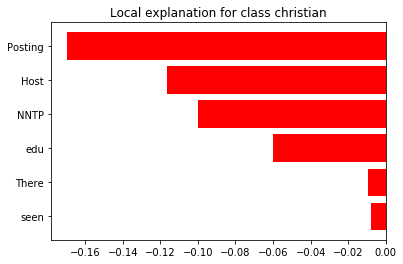

In [12]:
%matplotlib inline
fig = exp.as_pyplot_figure()

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs.  


In [13]:
exp.show_in_notebook(text=False)

Alternatively, we can save the fully contained html page to a file:

In [14]:
exp.save_to_file('/tmp/oi.html')

Finally, we can also include a visualization of the original document, with the words in the explanations highlighted. Notice how the words that affect the classifier the most are all in the email header.

In [15]:
exp.show_in_notebook(text=True)

That's it for this tutorial. Random forests were just an example, this explainer works for any classifier you may want to use, as long as it implements ````predict_proba````.